# Load analysis Data

In [1]:

import geopandas as gpd
from shapely.geometry import Point
import pandas as pd


# Function to clip dataframes using the US states shapefile
def clip_data_with_us_states(df, lon_col='lon', lat_col='lat'):
    """
    Clip a dataframe using US states shapefile
    """
    # Create geometry points from coordinates
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    
    # Ensure US states has the same CRS
    us_states_4326 = us_states.to_crs('EPSG:4326')
    
    # Perform spatial join to find points within US states
    clipped_gdf = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    
    # Remove geometry columns and keep original data
    clipped_df = clipped_gdf.drop(columns=['geometry', 'index_right'])
    
    # Remove any additional columns from the shapefile that might have been added
    shapefile_columns = us_states.columns.tolist()
    for col in shapefile_columns:
        if col in clipped_df.columns:
            clipped_df = clipped_df.drop(columns=[col])
    
    return clipped_df

# # Clip all your dataframes
# df_economic = clip_data_with_us_states(df_economic)
# df_weight = clip_data_with_us_states(df_weight)
# df_strategies = clip_data_with_us_states(df_strategies)
# df_net_benefit = clip_data_with_us_states(df_net_benefit)
# df_pv_npv = clip_data_with_us_states(df_pv_npv)
# df_agricultural_npv = clip_data_with_us_states(df_agricultural_npv)
# df_afforestation_npv = clip_data_with_us_states(df_afforestation_npv)
# df_natural_npv = clip_data_with_us_states(df_natural_npv)

df_economic = pd.read_csv('data/US_data/df_economic.csv')
df_weight = pd.read_csv('data/US_data/df_weight.csv')
df_strategies = pd.read_csv('data/US_data/df_strategies.csv')
df_net_benefit = pd.read_csv('data/US_data/df_net_benefit.csv')
df_pv_npv = pd.read_csv('data/US_data/df_pv_npv.csv')
df_agricultural_npv = pd.read_csv('data/US_data/df_agricultural_npv.csv')
df_afforestation_npv = pd.read_csv('data/US_data/df_afforestation_npv.csv')
df_natural_npv = pd.read_csv('data/US_data/df_natural_npv.csv')
df_pixel_optimized_data = pd.read_csv('data/US_data/df_pixel_optimized_data.csv')


us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')





In [4]:
df_strategies['area_m2'].sum()


43769727751.856766

In [6]:
(df_strategies['acc_forest'] * df_strategies['area_m2']).sum()


11204614815722.008

In [36]:
# Match rows by 'lat' and 'lon' before multiplying and summing, then convert from m2 to ha (1 ha = 10,000 m2)
merged = pd.merge(
    df_weight[['lat', 'lon', 'pv_potential_dens', 'Expectation_net_benefit']],
    df_strategies[['lat', 'lon', 'area_m2']],
    on=['lat', 'lon'],
    how='inner'
)

# pv_potential_dens is in Mg C (megagrams of carbon) per m2
# First, calculate total Mg C
total_MgC = (merged['pv_potential_dens'] * merged['area_m2']).sum() / 10000  # Convert to per hectare if needed

# Convert Mg C to Gt C (1 Gt = 1e12 kg, 1 Mg = 1e3 kg, so 1 Gt = 1e9 Mg)
total_GtC = total_MgC / 1e9

# Convert Gt C to Gt CO2 (1 t C = 3.667 t CO2, so 1 Gt C = 3.667 Gt CO2)
total_GtCO2 = total_GtC * 3.667

print(f"Total Mg C: {total_MgC:.2e} Mg C")
print(f"Total Gt C: {total_GtC:.4f} Gt C")
print(f"Total Gt CO2: {total_GtCO2:.4f} Gt CO2")


Total Mg C: 2.86e+10 Mg C
Total Gt C: 28.6320 Gt C
Total Gt CO2: 104.9934 Gt CO2


In [22]:
# Display the proportion of pixels where weighted_density_Forest is greater than 90%
proportion_above_90 = (df_weight['weighted_density_Forest'] > 0.7).mean()
print(f"Proportion of pixels with weighted_density_Forest > 70%: {proportion_above_90:.2%}")

Proportion of pixels with weighted_density_Forest > 70%: 66.22%


In [37]:
# 期望净效益的单位是 Mg（兆克），将其转化为 Gt C 和 Gt CO2
# 1. 先计算总的 Mg
total_Mg = ((merged['Expectation_net_benefit'] * merged['area_m2']).sum()) / 10000  # 先转为ha后求和，单位仍为Mg

# 2. Mg 转 Gt C（1 Gt = 1e9 Mg）
total_GtC = total_Mg / 1e9

# 3. Gt C 转 Gt CO2（1 t C = 3.667 t CO2）
total_GtCO2 = total_GtC * 3.667

print(f"Total Mg: {total_Mg:.2e} Mg")
print(f"Total Gt C: {total_GtC:.4f} Gt C")
print(f"Total Gt CO2: {total_GtCO2:.4f} Gt CO2")


Total Mg: 2.76e+10 Mg
Total Gt C: 27.5746 Gt C
Total Gt CO2: 101.1162 Gt CO2


In [39]:
opp=104.9934 - 101.1162 
opp

3.8771999999999878

In [23]:
total_pv_potential = (merged['pv_potential_dens'] * merged['area_m2']).sum() / 10000  
expected_net_benefit =((merged['Expectation_net_benefit'] * merged['area_m2']).sum()) / 10000

total_pv_potential/(total_pv_potential-expected_net_benefit)

27.08002630231859

In [26]:
df_economic

,lat,lon,pv_category,pv_model,pv_scenario,policy_category,rcp_category,net_npv_usd,net_cost_usd,analysis_year
0,31.320833,-105.929170,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364320e+06,2.364320e+06,2020
1,31.329166,-105.929170,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364268e+06,2.364268e+06,2020
2,31.337500,-105.937500,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364232e+06,2.364232e+06,2020
3,31.337500,-105.929170,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364223e+06,2.364223e+06,2020
4,31.345833,-105.937500,C1,REMIND 2.1,CEMICS_GDPgrowth_1p5,P2a,RCP2.6,-2.364196e+06,2.364196e+06,2020
...,...,...,...,...,...,...,...,...,...,...
68880915,46.937500,-67.920830,C7,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,RCP8.5,4.447125e+06,4.654054e+06,2050
68880916,47.145832,-67.962500,C7,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,RCP8.5,4.148731e+06,4.654008e+06,2050
68880917,47.237500,-68.620834,C7,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,RCP8.5,4.294753e+06,4.654032e+06,2050
68880918,47.254166,-68.354164,C7,TIAM-ECN 1.1,EN_NPi2100_COV,P1b,RCP8.5,4.331141e+06,4.654020e+06,2050


In [28]:
economic_2050 = df_economic[df_economic['analysis_year'] == 2050]
avg_npv = economic_2050.groupby(['lon', 'lat'])['net_npv_usd'].mean().reset_index()
avg_npv.columns = ['lon', 'lat', 'avg_npv']

In [30]:
# Calculate the proportion of grid cells where avg_npv is greater than zero
proportion_gt_zero = (avg_npv['avg_npv'] > 0).mean()
print(f"Proportion of grid cells with avg_npv > 0: {proportion_gt_zero:.2%}")

Proportion of grid cells with avg_npv > 0: 30.59%


In [32]:
from function import *
import xarray as xr

ds_merge=load_all_ds()

ds_merge

c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 174
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
c:\Users\zpy10\anacon

<xarray.Dataset> Size: 3TB
Dimensions:                   (time: 31, lat: 21600, lon: 43200)
Coordinates:
  * time                      (time) datetime64[ns] 248B 1992-01-01 ... 2022-...
    spatial_ref               int32 4B 0
    band                      int32 4B 1
  * lon                       (lon) float32 173kB -180.0 -180.0 ... 180.0 180.0
  * lat                       (lat) float32 86kB -90.0 -89.99 ... 89.99 90.0
Data variables: (12/20)
    abandonment_year          (time, lat, lon) float32 116GB dask.array<chunksize=(31, 500, 496), meta=np.ndarray>
    abandonment_duration      (time, lat, lon) float32 116GB dask.array<chunksize=(31, 500, 496), meta=np.ndarray>
    recultivation             (time, lat, lon) float32 116GB dask.array<chunksize=(31, 500, 496), meta=np.ndarray>
    current_abandonment       (time, lat, lon) float32 116GB dask.array<chunksize=(31, 500, 496), meta=np.ndarray>
    landcover                 (time, lat, lon) float32 116GB dask.array<chunksize=(16, 250, 249), meta=np.ndarray>
    DEM                       (time, lat, lon) float32 116GB dask.array<chunksize=(31, 1440, 2880), meta=np.ndarray>
    ...                        ...
    rsds                      (time, lat, lon) float32 116GB dask.array<chunksize=(1, 3085, 6172), meta=np.ndarray>
    SecondaryRoad             (time, lat, lon) float64 231GB dask.array<chunksize=(31, 981, 1964), meta=np.ndarray>
    Slope                     (time, lat, lon) float32 116GB dask.array<chunksize=(31, 1440, 2880), meta=np.ndarray>
    tas                       (time, lat, lon) float64 231GB dask.array<chunksize=(1, 2700, 5400), meta=np.ndarray>
    TertiaryRoad              (time, lat, lon) float64 231GB dask.array<chunksize=(31, 981, 1964), meta=np.ndarray>
    wind                      (time, lat, lon) float32 116GB dask.array<chunksize=(1, 432, 500), meta=np.ndarray>

# Result

## 撂荒地空间分布分析

In [33]:
df_net_benefit

,Unnamed: 0,time,lat,lon,abandonment_year,abandonment_duration,current_abandonment,landcover,DEM,GDPpc,...,env_scores,I,T_amb_C,T_cell,PR,PVPOT,area_m2,E_yr_per_m2,E_yr_pixel,carbon_emission (t)/yr
0,1897288,2020-01-01,31.320833,-105.929170,2014.0,10.0,1,2.0,1074.1250,19547.0,...,0.303154,246.944317,20.341527,26.194102,0.994029,0.245470,733498.229916,292.443061,2.145065e+08,75506.276537
1,1899788,2020-01-01,31.329166,-105.929170,2014.0,10.0,1,3.0,1074.8125,19547.0,...,0.309634,246.924653,20.332918,26.183108,0.994084,0.245464,733433.307337,292.435944,2.144823e+08,75497.755954
2,1902287,2020-01-01,31.337500,-105.937500,2014.0,10.0,1,3.0,1075.3750,32645.0,...,0.243530,246.963588,20.308333,26.160370,0.994198,0.245531,733368.361450,292.515504,2.145216e+08,75511.608892
3,1902288,2020-01-01,31.337500,-105.929170,2014.0,10.0,1,2.0,1074.9375,32645.0,...,0.246765,246.947801,20.308470,26.149869,0.994251,0.245528,733368.361450,292.512253,2.145192e+08,75510.769494
4,1904787,2020-01-01,31.345833,-105.937500,2014.0,10.0,1,2.0,1075.9375,32645.0,...,0.436201,247.035995,20.308194,26.133438,0.994333,0.245636,733303.407843,292.640899,2.145946e+08,75537.288146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64977,20192249,2020-01-01,46.937500,-67.920830,1998.0,26.0,1,2.0,199.3750,33949.0,...,0.277116,147.400035,3.740140,6.713950,1.091430,0.160877,586266.096715,191.662252,1.123651e+08,39552.508234
64978,20247244,2020-01-01,47.145832,-67.962500,2000.0,24.0,1,2.0,223.0000,33949.0,...,0.303993,141.932402,3.487502,5.736209,1.096319,0.155603,583981.240638,185.379407,1.082581e+08,38106.849899
64979,20271365,2020-01-01,47.237500,-68.620834,2000.0,24.0,1,2.0,181.2500,33949.0,...,0.323132,145.254988,3.699337,7.198324,1.089008,0.158184,582973.435084,188.453970,1.098637e+08,38672.007792
64980,20275797,2020-01-01,47.254166,-68.354164,2000.0,24.0,1,2.0,244.9375,33949.0,...,0.297849,144.524034,3.358455,5.205510,1.098972,0.158828,582790.047316,189.221245,1.102763e+08,38817.242845


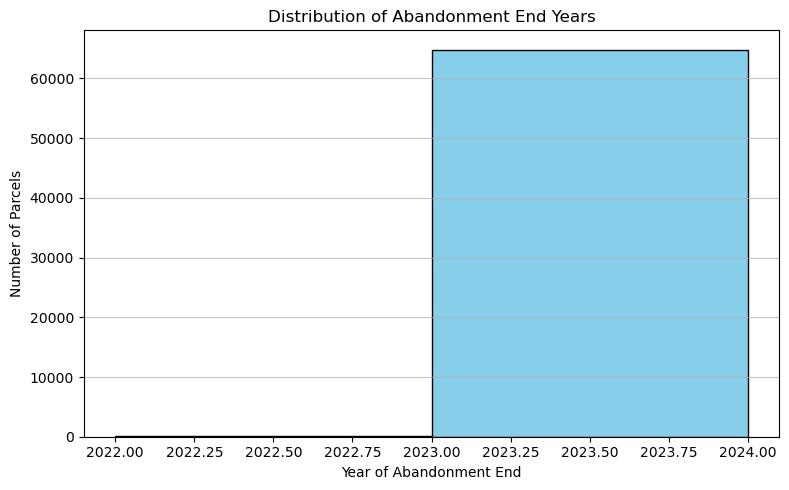

In [34]:
import matplotlib.pyplot as plt

# 计算撂荒地的分布年份（撂荒开始年份 + 持续时间）
distribution_year = df_net_benefit['abandonment_year'] + df_net_benefit['abandonment_duration']

# 绘制分布的直方图
plt.figure(figsize=(8,5))
plt.hist(distribution_year, bins=range(int(distribution_year.min()), int(distribution_year.max())+1), color='skyblue', edgecolor='black')
plt.xlabel('Year of Abandonment End')
plt.ylabel('Number of Parcels')
plt.title('Distribution of Abandonment End Years')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()


Average annual growth rate (from initial to terminal state): 19.89%


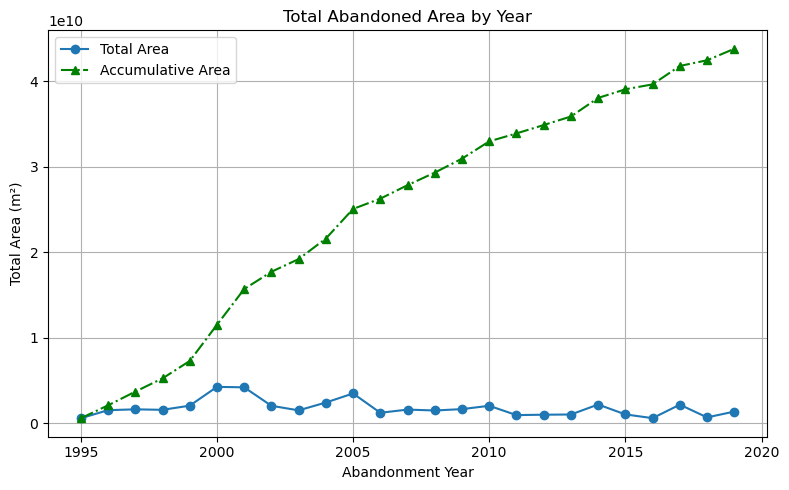

In [31]:
# Group by abandonment_year and sum area_m2 for each year
area_sum_by_year = df_net_benefit.groupby('abandonment_year')['area_m2'].sum().reset_index()

# Calculate accumulative (cumulative) area
area_sum_by_year['accumulative_area'] = area_sum_by_year['area_m2'].cumsum()

# Calculate average growth rate between initial and terminal state
initial_area = area_sum_by_year['accumulative_area'].iloc[0]
final_area = area_sum_by_year['accumulative_area'].iloc[-1]
n_years = area_sum_by_year['abandonment_year'].iloc[-1] - area_sum_by_year['abandonment_year'].iloc[0]

if initial_area > 0 and n_years > 0:
    avg_growth_rate = ( (final_area / initial_area) ** (1 / n_years) - 1 ) * 100
else:
    avg_growth_rate = float('nan')

print(f"Average annual growth rate (from initial to terminal state): {avg_growth_rate:.2f}%")

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8,5))

# Plot total area per year
ax1.plot(area_sum_by_year['abandonment_year'], area_sum_by_year['area_m2'], marker='o', label='Total Area')
ax1.set_xlabel('Abandonment Year')
ax1.set_ylabel('Total Area (m²)')
ax1.set_title('Total Abandoned Area by Year')
ax1.grid(True)

# Plot accumulative area on the same y-axis but as a dashed line
ax1.plot(area_sum_by_year['abandonment_year'], area_sum_by_year['accumulative_area'], color='green', marker='^', linestyle='-.', label='Accumulative Area')

ax1.legend(loc='upper left')

plt.tight_layout()
plt.show()

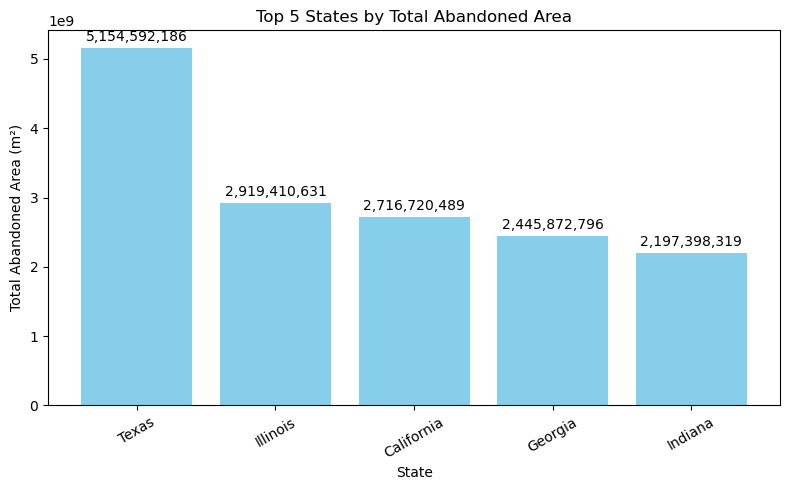

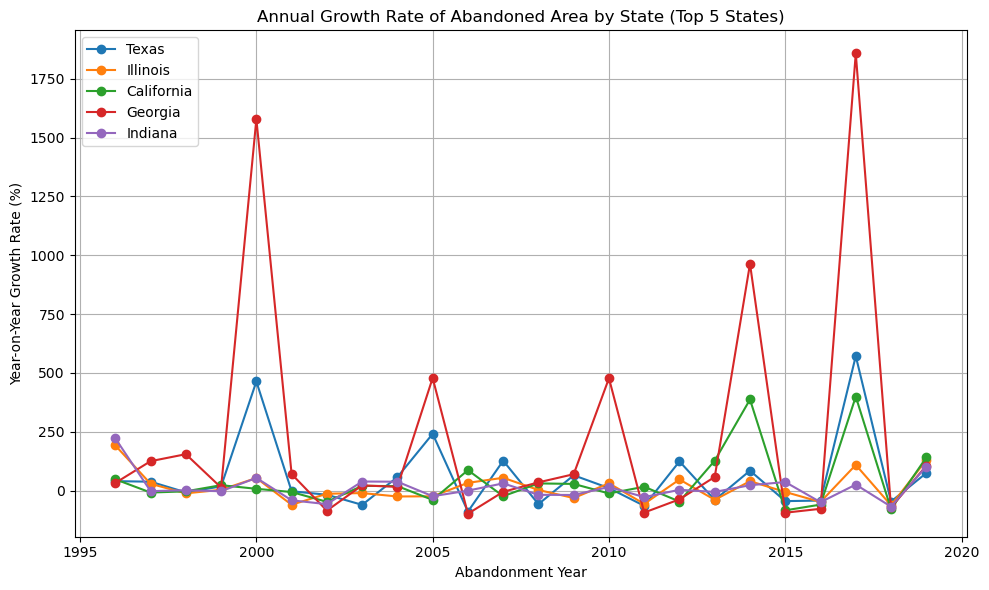

Top 10 states by latest year-on-year growth rate:
              NAME  area_growth_rate
702       New York       1325.967993
1017      Virginia       1006.286495
902   South Dakota        500.131044
850   Pennsylvania        434.935245
24         Alabama        329.014119
677     New Mexico        310.482186
545       Missouri        269.737931
750   North Dakota        200.243932
825         Oregon        192.255064
307           Iowa        188.134590

High-growth states by region (latest year):
Region
Other                31
Mid-Atlantic          7
Gulf Coast            5
Pacific Northwest     2
Name: count, dtype: int64

Top 10 high-growth states in target regions:
                NAME  area_growth_rate             Region
702         New York       1325.967993       Mid-Atlantic
1017        Virginia       1006.286495       Mid-Atlantic
24           Alabama        329.014119         Gulf Coast
825           Oregon        192.255064  Pacific Northwest
1042      Washington        140.9

In [29]:
# According to state, count the abandoned land area, find the top 5 states, 
# plot a bar chart, and also plot annual growth rates by state.
# Additionally, check if growth mainly occurs along the Mid-Atlantic Coast, Gulf Coast, and Pacific Northwest.

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

# Read US states shapefile and ensure CRS is WGS84
us_states = gpd.read_file('data/cb_2018_us_state_500k.shp')
us_states_4326 = us_states.to_crs('EPSG:4326')

# Create GeoDataFrame for pixels
geometry = [Point(xy) for xy in zip(df_net_benefit['lon'], df_net_benefit['lat'])]
pixel_gdf = gpd.GeoDataFrame(df_net_benefit, geometry=geometry, crs='EPSG:4326')

# Spatial join: assign each pixel to a state (adds all us_states_4326 columns, including 'NAME')
pixel_with_states = gpd.sjoin(pixel_gdf, us_states_4326, how='left', predicate='within')

# Use the correct state name column (commonly 'NAME' in US Census shapefiles)
state_col = 'NAME' if 'NAME' in pixel_with_states.columns else 'STATE_NAME'

# 1. Group by state and sum total area
state_area = pixel_with_states.groupby(state_col)['area_m2'].sum().reset_index()

# 2. Find the top 5 states by area
top5_states = state_area.sort_values(by='area_m2', ascending=False).head(5)

# 3. Plot bar chart for top 5 states
plt.figure(figsize=(8,5))
bars = plt.bar(top5_states[state_col], top5_states['area_m2'], color='skyblue')
plt.xlabel('State')
plt.ylabel('Total Abandoned Area (m²)')
plt.title('Top 5 States by Total Abandoned Area')
plt.xticks(rotation=30)
plt.tight_layout()

# Annotate values on bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:,.0f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=10)
plt.show()

# 4. Calculate annual growth rate by state
# Group by state and abandonment_year, sum area
state_year_area = pixel_with_states.groupby([state_col, 'abandonment_year'])['area_m2'].sum().reset_index()

# Sort for pct_change
state_year_area = state_year_area.sort_values([state_col, 'abandonment_year'])

# Calculate year-on-year growth rate for each state
state_year_area['area_growth_rate'] = state_year_area.groupby(state_col)['area_m2'].pct_change() * 100

# 5. Plot annual growth rate for top 5 states
fig, ax = plt.subplots(figsize=(10,6))
for state in top5_states[state_col]:
    data = state_year_area[state_year_area[state_col] == state]
    ax.plot(data['abandonment_year'], data['area_growth_rate'], marker='o', label=state)
ax.set_xlabel('Abandonment Year')
ax.set_ylabel('Year-on-Year Growth Rate (%)')
ax.set_title('Annual Growth Rate of Abandoned Area by State (Top 5 States)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

# 6. Check if growth mainly occurs along the Mid-Atlantic Coast, Gulf Coast, and Pacific Northwest
# Define states in these regions
mid_atlantic = {'New York', 'New Jersey', 'Delaware', 'Maryland', 'Virginia', 'North Carolina', 'South Carolina'}
gulf_coast = {'Texas', 'Louisiana', 'Mississippi', 'Alabama', 'Florida'}
pacific_nw = {'Washington', 'Oregon'}

# Get all states with high recent growth (e.g., last available year)
latest_year = state_year_area['abandonment_year'].max()
latest_growth = state_year_area[state_year_area['abandonment_year'] == latest_year]
# Sort by growth rate, drop NaN
latest_growth = latest_growth.dropna(subset=['area_growth_rate']).sort_values('area_growth_rate', ascending=False)

# Print top 10 states by latest growth rate
print("Top 10 states by latest year-on-year growth rate:")
print(latest_growth[[state_col, 'area_growth_rate']].head(10))

# Check if high-growth states are in the defined regions
def region_label(state):
    if state in mid_atlantic:
        return 'Mid-Atlantic'
    elif state in gulf_coast:
        return 'Gulf Coast'
    elif state in pacific_nw:
        return 'Pacific Northwest'
    else:
        return 'Other'

latest_growth['Region'] = latest_growth[state_col].apply(region_label)
region_counts = latest_growth['Region'].value_counts()
print("\nHigh-growth states by region (latest year):")
print(region_counts)

# Optionally, print which of the top 10 are in the target regions
print("\nTop 10 high-growth states in target regions:")
print(latest_growth[latest_growth['Region'] != 'Other'][[state_col, 'area_growth_rate', 'Region']].head(10))


## 协同度空间分析

--- Economic ---
               Count  Proportion
economic_sign                   
negative       49189    0.756963
positive       15764    0.242590
zero              29    0.000446

--- Environmental ---
                    Count  Proportion
environmental_sign                   
negative            33851    0.520929
positive            31102    0.478625
zero                   29    0.000446

--- Emission ---
               Count  Proportion
emission_sign                   
negative       40001    0.615570
positive       24952    0.383983
zero              29    0.000446



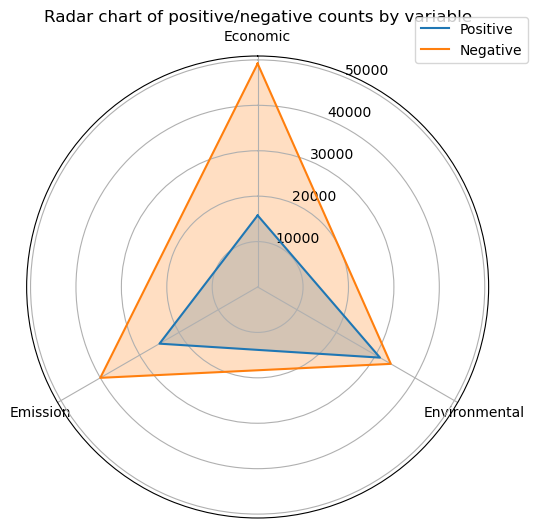

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume df_pixel_optimized_data contains weight_deviation_economic, weight_deviation_environmental, weight_deviation_emission

# 1. Assign sign labels
def sign_label(x):
    if x > 0:
        return 'positive'
    elif x < 0:
        return 'negative'
    else:
        return 'zero'

df_pixel_optimized_data['economic_sign'] = df_pixel_optimized_data['weight_deviation_economic'].apply(sign_label)
df_pixel_optimized_data['environmental_sign'] = df_pixel_optimized_data['weight_deviation_environmental'].apply(sign_label)
df_pixel_optimized_data['emission_sign'] = df_pixel_optimized_data['weight_deviation_emission'].apply(sign_label)

# 2. Count and proportion for each sign type in each dimension
summary = {}
total_count = len(df_pixel_optimized_data)
dimensions = ['economic_sign', 'environmental_sign', 'emission_sign']
dimension_names = ['Economic', 'Environmental', 'Emission']

for dim, name in zip(dimensions, dimension_names):
    counts = df_pixel_optimized_data[dim].value_counts()
    proportions = df_pixel_optimized_data[dim].value_counts(normalize=True)
    summary[name] = pd.DataFrame({
        'Count': counts,
        'Proportion': proportions
    })

# Display the count and proportion for each type in each dimension
for name in dimension_names:
    print(f"--- {name} ---")
    print(summary[name])
    print()

# 3. Prepare radar chart data (only positive and negative)
radar_data = pd.DataFrame({
    'Economic': [
        summary['Economic'].loc['positive', 'Count'] if 'positive' in summary['Economic'].index else 0,
        summary['Economic'].loc['negative', 'Count'] if 'negative' in summary['Economic'].index else 0
    ],
    'Environmental': [
        summary['Environmental'].loc['positive', 'Count'] if 'positive' in summary['Environmental'].index else 0,
        summary['Environmental'].loc['negative', 'Count'] if 'negative' in summary['Environmental'].index else 0
    ],
    'Emission': [
        summary['Emission'].loc['positive', 'Count'] if 'positive' in summary['Emission'].index else 0,
        summary['Emission'].loc['negative', 'Count'] if 'negative' in summary['Emission'].index else 0
    ]
}, index=['Positive', 'Negative'])

# 4. Plot radar chart for counts
labels = radar_data.columns
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for idx, row in radar_data.iterrows():
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, label=idx)
    ax.fill(angles, values, alpha=0.25)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.title('Radar chart of positive/negative counts by variable')
plt.show()

In [37]:
def analyze_all_dimensions_cross_target_difference(pixel_optimized_data, df_net_benefit):
    """
    分析所有三个维度的交叉目标差值
    """
    
    # 更优雅地merge：只merge一次，避免冗余，自动处理列名冲突
    # 检查必要列
    required_cols = {'lat', 'lon', 'area_m2'}
    if not required_cols.issubset(df_net_benefit.columns):
        missing = required_cols - set(df_net_benefit.columns)
        raise ValueError(f"df_net_benefit 缺少列: {missing}")
    if not {'lat', 'lon', 'avg_npv', 'env_scores', 'ccd_optimized', 'Expectation_net_benefit'}.issubset(pixel_optimized_data.columns):
        raise ValueError("pixel_optimized_data 缺少必要列")

    # merge时自动加后缀，避免同名冲突
    merged = pd.merge(
        pixel_optimized_data,
        df_net_benefit[['lat', 'lon', 'area_m2']],
        on=['lat', 'lon'],
        how='inner',
        validate='one_to_one',
        suffixes=('', '_area')
    )

    if merged.empty:
        raise ValueError("合并后没有数据，请检查lat, lon是否匹配")

    # 获取数据（转换为公顷）
    area_values = merged['area_m2'].values / 10000
    ccd_values = merged['ccd_optimized'].values
    economic_density = merged['avg_npv'].values
    env_density = merged['env_scores'].values
    carbon_density = merged['Expectation_net_benefit'].values

    # 计算总效益值
    economic_total = economic_density * area_values  # NPV需要乘以面积
    env_total = env_density  # Environmental Scores直接使用密度值
    carbon_total = carbon_density * area_values  # Carbon需要乘以面积
    
    # 计算总面积（公顷）
    total_area_ha = np.sum(area_values)
    
    # 定义三个维度
    dimensions = [
        {
            'name': 'Economic NPV',
            'total_values': economic_total,
            'density_values': economic_density,
            'unit': 'USD',
            'multiply_area': True
        },
        {
            'name': 'Environmental Scores',
            'total_values': env_total,
            'density_values': env_density,
            'unit': 'Score',
            'multiply_area': False
        },
        {
            'name': 'Carbon Mitigation',
            'total_values': carbon_total,
            'density_values': carbon_density,
            'unit': 'Mg C',
            'multiply_area': True
        }
    ]
    
    # 存储所有结果
    all_results = {}
    
    for dim_idx, current_dim in enumerate(dimensions):
        print(f"\n{'='*60}")
        print(f"=== {current_dim['name']}维度交叉目标差值分析 ===")
        print(f"{'='*60}")
        print(f"总面积: {total_area_ha:.2f} 公顷")
        
        current_total = current_dim['total_values']
        current_name = current_dim['name']
        current_unit = current_dim['unit']
        
        # 1. 按当前目标最优排序的累积效应
        current_sorted_indices = np.argsort(current_total)[::-1]
        current_optimal_cumulative = np.cumsum(current_total[current_sorted_indices])
        current_optimal_percentage = np.arange(1, len(current_optimal_cumulative) + 1) / len(current_optimal_cumulative) * 100
        
        # 确保从0开始
        current_optimal_cumulative = np.concatenate([[0], current_optimal_cumulative])
        current_optimal_percentage = np.concatenate([[0], current_optimal_percentage])
        
        # 2. 按其他目标排序在当前目标下的累积效应
        other_dimensions = [d for d in dimensions if d['name'] != current_name]
        other_cumulatives = {}
        
        for other_dim in other_dimensions:
            other_name = other_dim['name']
            other_total = other_dim['total_values']
            
            # 按其他目标排序
            other_sorted_indices = np.argsort(other_total)[::-1]
            other_optimal_cumulative = np.cumsum(current_total[other_sorted_indices])
            other_optimal_percentage = np.arange(1, len(other_optimal_cumulative) + 1) / len(other_optimal_cumulative) * 100
            
            # 确保从0开始
            other_optimal_cumulative = np.concatenate([[0], other_optimal_cumulative])
            other_optimal_percentage = np.concatenate([[0], other_optimal_percentage])
            
            other_cumulatives[other_name] = {
                'cumulative': other_optimal_cumulative,
                'percentage': other_optimal_percentage
            }
        
        # 统计当前目标最优累积效应的最大值及其分位数
        max_current_optimal_idx = np.argmax(current_optimal_cumulative)
        max_current_optimal_value = current_optimal_cumulative[max_current_optimal_idx]
        max_current_optimal_percentage = current_optimal_percentage[max_current_optimal_idx]
        
        print(f"\n=== {current_name}累积效应统计 ===")
        print(f"{current_name}最优累积效应最大值: {max_current_optimal_value:.2e}")
        print(f"对应分位数: {max_current_optimal_percentage:.2f}%")
        
        # 为NPV添加y=0分位数分析
        if current_name == 'Economic NPV':
            print(f"\n=== {current_name} 所有Y=0 分位数分析 ===")
            
            # 函数：找到所有零点
            def find_all_zeros(cumulative_values, percentage_values, tolerance=1e9):
                """找到累积曲线中所有接近0的点"""
                zeros = []
                
                # 方法1：直接寻找接近0的点
                for i in range(len(cumulative_values)):
                    if abs(cumulative_values[i]) <= tolerance:
                        zeros.append({
                            'index': i,
                            'percentage': percentage_values[i],
                            'value': cumulative_values[i]
                        })
                
                # 方法2：寻找符号变化点（更准确）
                sign_changes = []
                for i in range(1, len(cumulative_values)):
                    if (cumulative_values[i-1] * cumulative_values[i]) < 0:  # 符号变化
                        # 线性插值找到更精确的零点
                        x1, x2 = percentage_values[i-1], percentage_values[i]
                        y1, y2 = cumulative_values[i-1], cumulative_values[i]
                        zero_percentage = x1 - y1 * (x2 - x1) / (y2 - y1)
                        sign_changes.append({
                            'index': i,
                            'percentage': zero_percentage,
                            'value': 0.0
                        })
                
                # 合并两种方法的结果
                all_zeros = zeros + sign_changes
                
                # 去重并排序
                unique_zeros = []
                seen_percentages = set()
                for zero in sorted(all_zeros, key=lambda x: x['percentage']):
                    if not any(abs(zero['percentage'] - seen) < 1.0 for seen in seen_percentages):
                        unique_zeros.append(zero)
                        seen_percentages.add(zero['percentage'])
                
                return unique_zeros
            
            # 当前目标最优排序的所有零点
            current_zeros = find_all_zeros(current_optimal_cumulative, current_optimal_percentage)
            print(f"{current_name}最优排序下所有Y=0点:")
            for i, zero in enumerate(current_zeros):
                print(f"  零点{i+1}: {zero['percentage']:.2f}% (累积值: {zero['value']:.2e})")
            
            # 其他目标排序下的所有零点
            for other_name, other_data in other_cumulatives.items():
                other_zeros = find_all_zeros(other_data['cumulative'], other_data['percentage'])
                print(f"\n{other_name}排序下所有Y=0点:")
                for i, zero in enumerate(other_zeros):
                    print(f"  零点{i+1}: {zero['percentage']:.2f}% (累积值: {zero['value']:.2e})")
                
                # 分析零点差异
                print(f"\n{current_name}最优 vs {other_name}最优 零点分析:")
                if current_zeros and other_zeros:
                    # 找到最接近的零点对
                    min_diff = float('inf')
                    closest_pair = None
                    for c_zero in current_zeros:
                        for o_zero in other_zeros:
                            diff = abs(c_zero['percentage'] - o_zero['percentage'])
                            if diff < min_diff:
                                min_diff = diff
                                closest_pair = (c_zero, o_zero)
                    
                    if closest_pair:
                        c_zero, o_zero = closest_pair
                        print(f"最接近的零点对:")
                        print(f"  {current_name}最优: {c_zero['percentage']:.2f}%")
                        print(f"  {other_name}最优: {o_zero['percentage']:.2f}%")
                        print(f"  差异: {c_zero['percentage'] - o_zero['percentage']:.2f}%")
                else:
                    print("  无法找到匹配的零点对")
            
            # 分析零点数量
            print(f"\n零点数量统计:")
            print(f"{current_name}最优排序: {len(current_zeros)} 个零点")
            for other_name, other_data in other_cumulatives.items():
                other_zeros = find_all_zeros(other_data['cumulative'], other_data['percentage'])
                print(f"{other_name}排序: {len(other_zeros)} 个零点")
        
        # 分析与其他目标的差值
        for other_name, other_data in other_cumulatives.items():
            print(f"\n{current_name}最优 vs {other_name}最优 差值分析:")
            
            # 计算差值
            diff_current_vs_other = current_optimal_cumulative - other_data['cumulative']
            
            # 找到最大差值及其位置
            max_diff_idx = np.argmax(diff_current_vs_other)
            max_diff_percentage = current_optimal_percentage[max_diff_idx]
            max_diff_value = diff_current_vs_other[max_diff_idx]
            max_current_optimal_at_diff = current_optimal_cumulative[max_diff_idx]
            max_other_optimal_at_diff = other_data['cumulative'][max_diff_idx]
            
            # 计算最大和最小累积值
            max_current_total = np.max(current_optimal_cumulative)
            min_current_total = np.min(current_optimal_cumulative)
            max_other_total = np.max(other_data['cumulative'])
            min_other_total = np.min(other_data['cumulative'])
            
            # 均摊到地块上的值
            max_current_per_ha = max_current_total / total_area_ha
            min_current_per_ha = min_current_total / total_area_ha
            max_other_per_ha = max_other_total / total_area_ha
            min_other_per_ha = min_other_total / total_area_ha
            max_diff_per_ha = max_diff_value / total_area_ha
            
            print(f"最大差值: {max_diff_value:.2e}")
            print(f"发生在分位数: {max_diff_percentage:.1f}%")
            print(f"对应的{current_name}最优累积值: {max_current_optimal_at_diff:.2e}")
            print(f"对应的{other_name}最优累积值: {max_other_optimal_at_diff:.2e}")
            print(f"\n累积值范围分析:")
            print(f"{current_name}累积值范围: {min_current_total:.2e} - {max_current_total:.2e}")
            print(f"{other_name}累积值范围: {min_other_total:.2e} - {max_other_total:.2e}")
            print(f"\n均摊到地块上的值 ({current_unit}/公顷):")
            print(f"{current_name}: {min_current_per_ha:.2f} - {max_current_per_ha:.2f}")
            print(f"{other_name}: {min_other_per_ha:.2f} - {max_other_per_ha:.2f}")
            print(f"最大差值: {max_diff_per_ha:.2f}")
            
            # 分析关键分位数的差值
            key_percentages = [3, 10, 20, 30, 40, 50, 60, 70, 80, 90]
            print(f"\n关键分位数差值分析 ({current_name}最优 - {other_name}最优):")
            print(f"{'分位数(%)':<10} {'{current_name}最优':<15} {'{other_name}最优':<15} {'差值':<15} {'差值/公顷':<15}")
            print("-" * 75)
            
            for p in key_percentages:
                idx = np.argmin(np.abs(current_optimal_percentage - p))
                if idx < len(current_optimal_cumulative):
                    current_val = current_optimal_cumulative[idx]
                    other_val = other_data['cumulative'][idx]
                    diff_val = current_val - other_val
                    diff_per_ha = diff_val / total_area_ha
                    print(f"{p:<10} {current_val:<15.2e} {other_val:<15.2e} {diff_val:<15.2e} {diff_per_ha:<15.2f}")
            
            # 存储结果
            if current_name not in all_results:
                all_results[current_name] = {}
            
            all_results[current_name][other_name] = {
                'max_diff': max_diff_value,
                'max_diff_percentage': max_diff_percentage,
                'max_current': max_current_optimal_at_diff,
                'max_other': max_other_optimal_at_diff,
                'max_current_total': max_current_total,
                'min_current_total': min_current_total,
                'max_other_total': max_other_total,
                'min_other_total': min_other_total,
                'max_current_per_ha': max_current_per_ha,
                'min_current_per_ha': min_current_per_ha,
                'max_other_per_ha': max_other_per_ha,
                'min_other_per_ha': min_other_per_ha,
                'max_diff_per_ha': max_diff_per_ha
            }
    
    print(f"\n{'='*60}")
    print("=== 所有维度分析完成 ===")
    print(f"{'='*60}")
    
    return all_results

# 执行所有维度分析
all_dimensions_results = analyze_all_dimensions_cross_target_difference(df_pixel_optimized_data, df_net_benefit)


=== Economic NPV维度交叉目标差值分析 ===
总面积: 4376972.78 公顷

=== Economic NPV累积效应统计 ===
Economic NPV最优累积效应最大值: 6.98e+11
对应分位数: 30.59%

=== Economic NPV 所有Y=0 分位数分析 ===
Economic NPV最优排序下所有Y=0点:
  零点1: 0.00% (累积值: 0.00e+00)
  零点2: 85.20% (累积值: 9.78e+08)

Environmental Scores排序下所有Y=0点:
  零点1: 0.00% (累积值: 0.00e+00)

Economic NPV最优 vs Environmental Scores最优 零点分析:
最接近的零点对:
  Economic NPV最优: 0.00%
  Environmental Scores最优: 0.00%
  差异: 0.00%

Carbon Mitigation排序下所有Y=0点:
  零点1: 0.00% (累积值: 0.00e+00)
  零点2: 83.90% (累积值: 9.82e+08)

Economic NPV最优 vs Carbon Mitigation最优 零点分析:
最接近的零点对:
  Economic NPV最优: 0.00%
  Carbon Mitigation最优: 0.00%
  差异: 0.00%

零点数量统计:
Economic NPV最优排序: 2 个零点
Environmental Scores排序: 1 个零点
Carbon Mitigation排序: 2 个零点

Economic NPV最优 vs Environmental Scores最优 差值分析:
最大差值: 1.20e+12
发生在分位数: 45.5%
对应的Economic NPV最优累积值: 6.39e+11
对应的Environmental Scores最优累积值: -5.63e+11

累积值范围分析:
Economic NPV累积值范围: -4.59e+11 - 6.98e+11
Environmental Scores累积值范围: -6.38e+11 - 1.11e+09

均摊到地块上的值 (USD/公顷):
Economic

In [ ]:

if abs(-5.65e+11) > 0:
    ratio = abs(6.39e+11) / abs(-5.63e+11)
    print(f"Economic最优累计值是Environmental最优累计值的{ratio:.2f}倍")
    print(f"也就是说，要赚{ratio:.2f}倍的成本")
else:
    print("Environmental最优累计值为0，无法计算倍数差距。")


Economic最优累计值是Environmental最优累计值的1.13倍
也就是说，要赚1.13倍的成本


## 碳汇分析

### 累积效应分析（分策略碳汇类型）

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



=== 各碳汇类型最大累积百分比 ===
Agricultural: 5.8%
Vegetation: 13.9%
Forest: 79.3%
Total: 98.9%


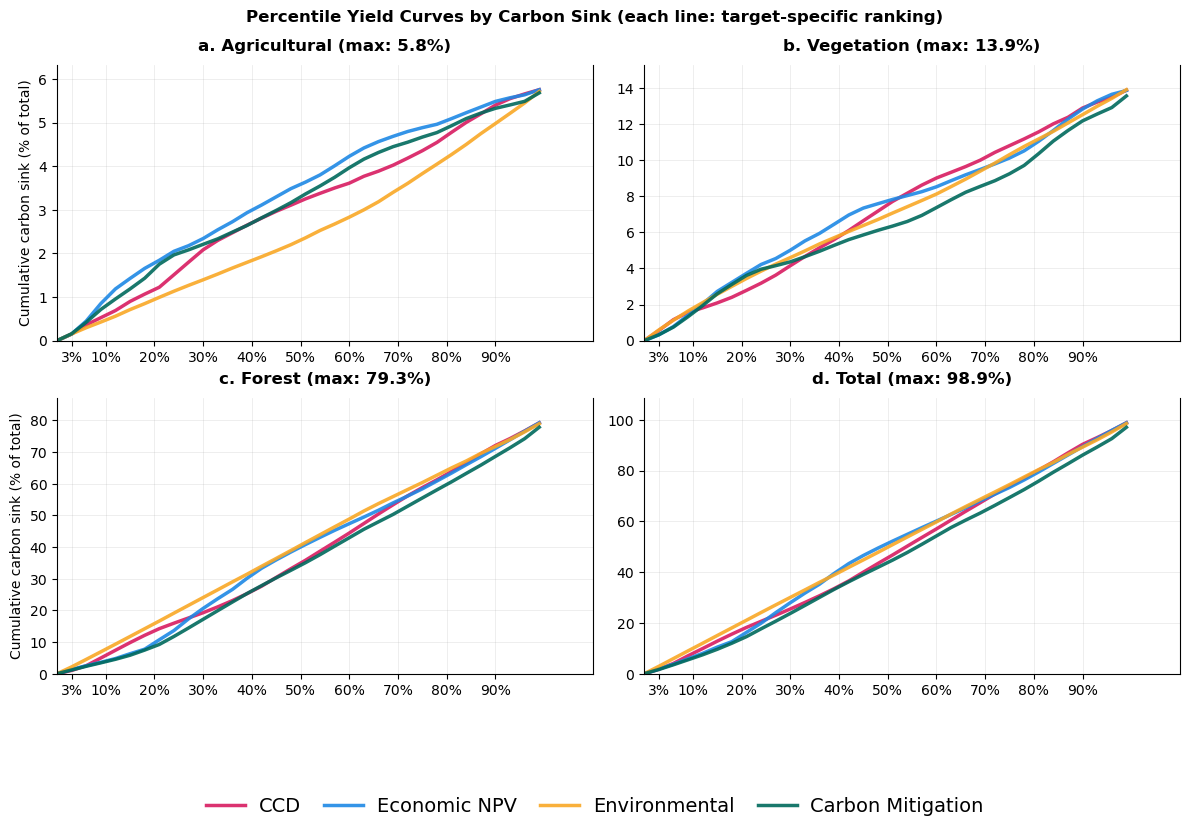

百分位数小倍数图创建完成！


In [30]:
def percentile_small_multiples(pixel_optimized_data, df_net_benefit, df_weight,
                               percentiles=np.arange(3,101,3),  # 从3%开始，每3%一个点
                               targets=(('ccd_optimized','CCD'),
                                        ('avg_npv','Economic NPV'),
                                        ('env_scores','Environmental'),
                                        ('Expectation_net_benefit','Carbon Mitigation'))):
    m = (pixel_optimized_data
         .merge(df_net_benefit[['lat','lon','area_m2']], on=['lat','lon'], how='inner')
         .merge(df_weight[['lat','lon',
                           'final_forest','weighted_density_Forest',
                           'final_agro','weighted_density_Agricultural',
                           'final_veg','weighted_density_Vegetation']], on=['lat','lon'], how='inner'))
    ha = (m['area_m2'].values/10000.0)
    forest = m['final_forest'].values * m['weighted_density_Forest'].values * ha
    agro   = m['final_agro'].values   * m['weighted_density_Agricultural'].values * ha
    veg    = m['final_veg'].values    * m['weighted_density_Vegetation'].values * ha
    total  = forest + agro + veg
    sinks = [('Agricultural', agro),
             ('Vegetation',   veg),
             ('Forest',       forest),
             ('Total',        total)]

    base_colors = ['#D81B60','#1E88E5','#F9A825','#00695C']
    x = percentiles

    # 改为2行2列布局
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 调整尺寸适应2x2布局
    axes = axes.flatten()  # 将axes展平为一维数组
    
    # 用于收集图例元素
    legend_elements = []
    
    # 统一使用Total Carbon作为归一化基准
    total_max = np.sum(total)  # Total Carbon的总和作为统一基准
    
    # 存储每个子图的最大值，用于设置Y轴范围
    max_percentages = []
    
    for ax_idx, (sname, svals) in enumerate(sinks):
        ax = axes[ax_idx]
        
        # 去除顶部边框
        ax.spines['top'].set_visible(False)
        
        # 存储当前子图的所有Y值，用于计算最大值
        all_y_values = []
        
        for ci,(tcol,tname) in enumerate(targets):
            order = np.argsort(m[tcol].values)[::-1]
            cum = np.cumsum(svals[order])
            
            # 确保从0开始，包含0点
            cum_with_zero = np.concatenate([[0], cum])
            x_with_zero = np.concatenate([[0], x])
            
            # 计算每个分位数对应的累积值
            y_values = []
            for p in x_with_zero:
                if p == 0:
                    y_values.append(0)
                else:
                    idx = int((p/100.0) * len(cum))
                    if idx < len(cum):
                        y_values.append(cum[idx])
                    else:
                        y_values.append(cum[-1])
            
            # 统一使用Total Carbon作为归一化基准，转换为百分比
            y = np.array(y_values) / total_max * 100  # 转换为百分比
            all_y_values.extend(y)  # 收集所有Y值
            
            line = ax.plot(x_with_zero, y, lw=2.5, alpha=0.9, label=tname, color=base_colors[ci])
            
            # 收集图例元素（只在第一个子图中收集，避免重复）
            if ax_idx == 0:
                legend_elements.append(line[0])

        # 计算当前子图的最大值，并设置Y轴范围
        max_y = max(all_y_values)
        max_percentages.append(max_y)
        
        # 设置Y轴范围：从0到最大值的1.1倍，确保有足够空间
        y_max = max_y * 1.1
        ax.set_ylim(0, y_max)

        # 设置X轴刻度（按照cross_target_analysis的样式，从3%开始）
        key_percentages = [3, 10, 20, 30, 40, 50, 60, 70, 80, 90]
        xtick_positions = [p for p in key_percentages if p >= 3]
        xtick_labels = [f'{p}%' for p in xtick_positions]
        
        ax.set_xticks(xtick_positions)
        ax.set_xticklabels(xtick_labels, ha='center', fontsize=10)
        ax.set_xlim(0, 110)  # 稍微扩展一点，为文本标签留空间
        
        # 设置Y轴标签（只在左侧子图显示）
        if ax_idx in [0, 2]:  # 左侧子图
            ax.set_ylabel('Cumulative carbon sink (% of total)', fontsize=10)
        
        # 网格设置（按照cross_target_analysis的样式）
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
        ax.set_axisbelow(True)
        
        # 刻度设置
        ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
        
        # 子图标题（使用a, b, c, d），并显示最大值
        ax.set_title(f'{chr(97+ax_idx)}. {sname} (max: {max_y:.1f}%)', fontsize=12, fontweight='bold', pad=10)

    # 添加图例（按照cross_target_analysis的样式）
    fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), 
               ncol=4, fontsize=14, frameon=False, fancybox=False, shadow=False, framealpha=0.9,
               columnspacing=1.2, handletextpad=0.7)

    # 总标题
    fig.suptitle('Percentile Yield Curves by Carbon Sink (each line: target-specific ranking)',
                 y=0.98, fontsize=12, weight='bold')
    
    # 布局设置（按照cross_target_analysis的样式）
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # 为更大的底部图例留出空间
    
    # 打印每个子图的最大值信息
    print("\n=== 各碳汇类型最大累积百分比 ===")
    for i, (sname, _) in enumerate(sinks):
        print(f"{sname}: {max_percentages[i]:.1f}%")
    
    return fig, axes

# 执行函数
fig_percentile, axes_percentile = percentile_small_multiples(df_pixel_optimized_data, df_net_benefit, df_weight)

# 保存图形
fig_percentile.savefig('figure/US_figure/Figure_percentile_small_multiples.eps', bbox_inches='tight', dpi=300, format='eps')
fig_percentile.savefig('figure/US_figure/Figure_percentile_small_multiples.png', bbox_inches='tight', dpi=300, format='png')
plt.show()

print("百分位数小倍数图创建完成！")

### 最大差异分析
（主要逻辑： 对比各个维度下的最优曲线，单目标与最优曲线的差距、以及这个差距除以最优曲线所造成的的性能损失）

### 概率分布分析

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import geopandas as gpd
from shapely.geometry import Point

df_weight = pd.read_csv('data/US_data/df_weight.csv')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')

# 提取 us_states 里的 Name 字段，并根据 df_weight 的 'lat' 和 'lon' 匹配
# 首先将 df_weight 转为 GeoDataFrame
geometry = [Point(xy) for xy in zip(df_weight['lon'], df_weight['lat'])]
df_weight_gdf = gpd.GeoDataFrame(df_weight, geometry=geometry, crs=us_states.crs)

# 使用 spatial join 匹配州名
df_weight_gdf = gpd.sjoin(df_weight_gdf, us_states[['geometry', 'NAME']], how='left', predicate='within')

# 将匹配到的州名添加到 df_weight
df_weight['state_name'] = df_weight_gdf['NAME']




In [ ]:
import numpy as np
from scipy import stats

def calculate_confidence_interval(data, confidence_level=0.95):
    """
    计算置信区间
    """
    mean = np.mean(data)
    std = np.std(data, ddof=1)  # 样本标准差
    n = len(data)
    
    # t分布临界值
    t_critical = stats.t.ppf((1 + confidence_level) / 2, df=n-1)
    
    # 标准误差
    standard_error = std / np.sqrt(n)
    
    # 置信区间
    margin_of_error = t_critical * standard_error
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    
    return lower_bound, upper_bound, margin_of_error

def calculate_proportion_confidence_interval(successes, n, confidence_level=0.95):
    """
    计算比例的置信区间（Wilson score interval）
    """
    if n == 0:
        return 0, 0, 0
    p = successes / n
    z = stats.norm.ppf(1 - (1 - confidence_level) / 2)
    denominator = 1 + z**2 / n
    centre = p + z**2 / (2 * n)
    margin = z * np.sqrt((p * (1 - p) + z**2 / (4 * n)) / n)
    lower_bound = (centre - margin) / denominator
    upper_bound = (centre + margin) / denominator
    return lower_bound, upper_bound, (upper_bound - lower_bound) / 2

def calculate_percentile_interval(data, lower_percentile=2.5, upper_percentile=97.5):
    """
    计算分位数区间（相当于95%置信区间）
    """
    lower_bound = np.percentile(data, lower_percentile)
    upper_bound = np.percentile(data, upper_percentile)
    return lower_bound, upper_bound

def analyze_carbon_sink_density(data, sink_name):
    """
    分析碳汇密度的完整统计信息
    """
    print(f"\n{'='*60}")
    print(f"=== {sink_name} 统计分析 ===")
    print(f"{'='*60}")
    
    # 基本统计
    print(f"样本量: {len(data)}")
    print(f"均值: {data.mean():.6f}")
    print(f"标准差: {data.std():.6f}")
    print(f"最小值: {data.min():.6f}")
    print(f"最大值: {data.max():.6f}")
    
    # 置信区间
    lower, upper, margin = calculate_confidence_interval(data)
    print(f"\n95%置信区间: [{lower:.6f}, {upper:.6f}]")
    print(f"误差范围: ±{margin:.6f}")
    
    # 分位数区间
    p_lower, p_upper = calculate_percentile_interval(data)
    print(f"95%分位数区间: [{p_lower:.6f}, {p_upper:.6f}]")
    
    # 汇报格式
    print(f"\n汇报格式:")
    print(f"{sink_name}: {data.mean():.6f} ± {margin:.6f} (95% CI)")
    print(f"{sink_name}: {data.mean():.6f} (95% CI: {lower:.6f}-{upper:.6f})")
    
    # 大于平均值的面积占比
    mean_density = data.mean()
    greater_than_mean = data[data > mean_density]
    n_total = len(data)
    n_greater = len(greater_than_mean)
    proportion = n_greater / n_total if n_total > 0 else 0
    
    # Wilson score interval for proportion
    prop_lower, prop_upper, prop_margin = calculate_proportion_confidence_interval(n_greater, n_total, confidence_level=0.95)
    
    print(f"\n大于平均值的面积占比: {proportion:.4%}")
    print(f"95%置信区间: [{prop_lower:.4%}, {prop_upper:.4%}]")
    print(f"误差范围: ±{prop_margin:.4%}")
    
    # 汇报格式
    print(f"Proportion of area with {sink_name.lower()} greater than mean: {proportion:.6%} ± {prop_margin:.6%} (95% CI)")
    print(f"Proportion of area with {sink_name.lower()} greater than mean: {proportion:.6%} (95% CI: {prop_lower:.6%}-{prop_upper:.6%})")
    
    return {
        'mean': data.mean(),
        'std': data.std(),
        'ci_lower': lower,
        'ci_upper': upper,
        'margin': margin,
        'percentile_lower': p_lower,
        'percentile_upper': p_upper,
        'proportion_greater_mean': proportion,
        'proportion_ci_lower': prop_lower,
        'proportion_ci_upper': prop_upper,
        'proportion_margin': prop_margin
    }

# 分析三个碳汇类型
carbon_sinks = {
    'Forest': df_weight['weighted_density_Forest'].dropna(),
    'Agricultural': df_weight['weighted_density_Agricultural'].dropna(),
    'Vegetation': df_weight['weighted_density_Vegetation'].dropna()
}

# 存储所有结果
all_results = {}

for sink_name, data in carbon_sinks.items():
    results = analyze_carbon_sink_density(data, sink_name)
    all_results[sink_name] = results

# 汇总比较
print(f"\n{'='*60}")
print("=== 三种碳汇类型汇总比较 ===")
print(f"{'='*60}")

print(f"{'碳汇类型':<15} {'均值':<12} {'标准差':<12} {'95%置信区间':<25} {'大于均值占比':<15}")
print("-" * 85)

for sink_name, results in all_results.items():
    print(f"{sink_name:<15} {results['mean']:<12.6f} {results['std']:<12.6f} "
          f"[{results['ci_lower']:.6f}, {results['ci_upper']:.6f}] "
          f"{results['proportion_greater_mean']:<15.4%}")

# 相对比较分析
print(f"\n=== 相对比较分析 ===")
total_mean = sum(results['mean'] for results in all_results.values())
print(f"三种碳汇类型均值总和: {total_mean:.6f}")

for sink_name, results in all_results.items():
    relative_proportion = results['mean'] / total_mean * 100
    print(f"{sink_name}相对占比: {relative_proportion:.2f}%")

# 变异系数比较
print(f"\n=== 变异系数比较 (CV = 标准差/均值) ===")
for sink_name, results in all_results.items():
    cv = results['std'] / results['mean'] if results['mean'] != 0 else 0
    print(f"{sink_name}变异系数: {cv:.4f}")

# 保存结果到文件（可选）
import pandas as pd

summary_df = pd.DataFrame({
    '碳汇类型': list(all_results.keys()),
    '均值': [results['mean'] for results in all_results.values()],
    '标准差': [results['std'] for results in all_results.values()],
    '95%置信区间下限': [results['ci_lower'] for results in all_results.values()],
    '95%置信区间上限': [results['ci_upper'] for results in all_results.values()],
    '误差范围': [results['margin'] for results in all_results.values()],
    '大于均值占比': [results['proportion_greater_mean'] for results in all_results.values()],
    '大于均值占比95%CI下限': [results['proportion_ci_lower'] for results in all_results.values()],
    '大于均值占比95%CI上限': [results['proportion_ci_upper'] for results in all_results.values()]
})

print(f"\n=== 结果汇总表 ===")
print(summary_df.to_string(index=False))

# # 保存到CSV文件
# summary_df.to_csv('carbon_sink_density_analysis.csv', index=False, encoding='utf-8-sig')
# print(f"\n结果已保存到 'carbon_sink_density_analysis.csv'")

95%置信区间: [0.7558, 0.7597]
误差范围: ±0.0019
=== Forest Density 统计分析 ===
样本量: 64982
均值: 0.7578
标准差: 0.2532
95%置信区间: [0.7558, 0.7597]
误差范围: ±0.0019
95%分位数区间: [0.0790, 1.0000]

汇报格式:
Forest density: 0.757783 ± 0.001947 (95% CI)
Forest density: 0.757783 (95% CI: 0.755836-0.759730)

大于平均值的面积占比: 60.1120%
95%置信区间: [59.7350%, 60.4879%]
误差范围: ±0.3765%
Proportion of area with forest density greater than mean: 60.112031% ± 0.376479% (95% CI)
Proportion of area with forest density greater than mean: 60.112031% (95% CI: 59.734954%-60.487912%)


前十州（按数量排序）:
        state_name  count  proportion
39           Texas   4079    0.104424
8          Georgia   3287    0.084148
10        Illinois   2658    0.068046
30  North Carolina   2008    0.051405
19        Michigan   2007    0.051380
11         Indiana   1857    0.047540
45       Wisconsin   1685    0.043137
15       Louisiana   1429    0.036583
3       California   1375    0.035200
21     Mississippi   1304    0.033383


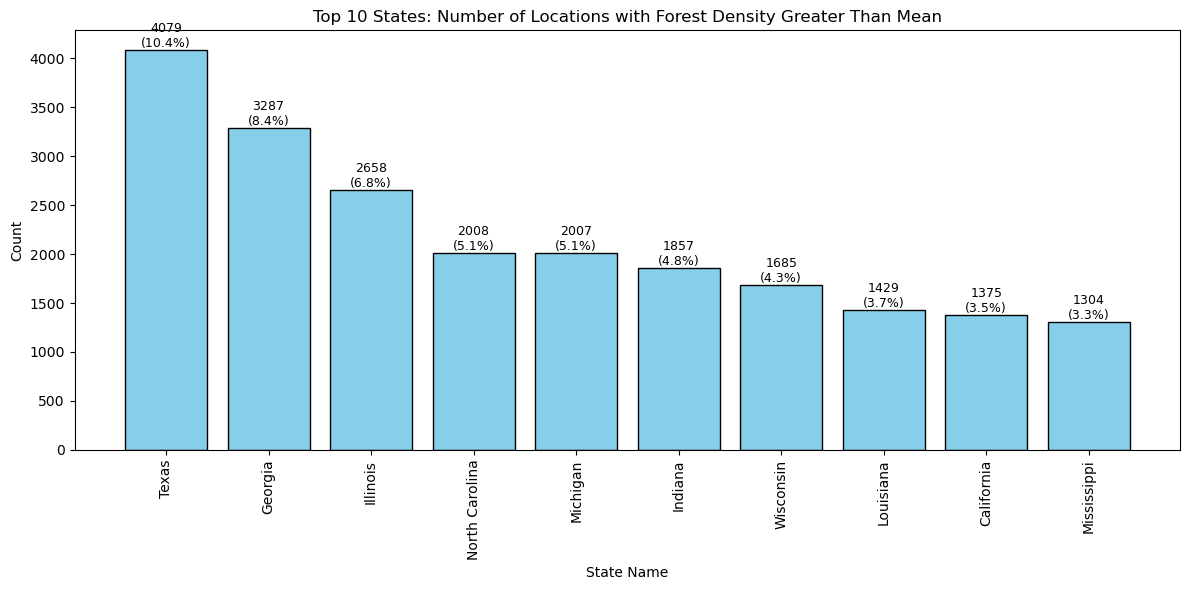

In [48]:
# 按state_name分组并计数，打印前十，并绘制州的分布柱状图，计算占总数的比例，以数据标记的方式呈现
import matplotlib.pyplot as plt

mean_density = forest_density.mean()
greater_than_mean = df_weight[df_weight['weighted_density_Forest'] > mean_density]

state_counts = greater_than_mean.groupby('state_name').size().reset_index(name='count')
state_counts = state_counts.sort_values(by='count', ascending=False)

total_count = greater_than_mean.shape[0]
state_counts['proportion'] = state_counts['count'] / total_count

# 打印前十
print("前十州（按数量排序）:")
print(state_counts.head(10))

# 只绘制前十
top10 = state_counts.head(10)

plt.figure(figsize=(12,6))
bars = plt.bar(top10['state_name'], top10['count'], color='skyblue', edgecolor='black')
plt.xlabel('State Name')
plt.ylabel('Count')
plt.title('Top 10 States: Number of Locations with Forest Density Greater Than Mean')
plt.xticks(rotation=90)
plt.tight_layout()

# 添加数据标记，显示数量和比例
for bar, count, prop in zip(bars, top10['count'], top10['proportion']):
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        bar.get_height(), 
        f'{count}\n({prop:.1%})', 
        ha='center', va='bottom', fontsize=9
    )

plt.show()


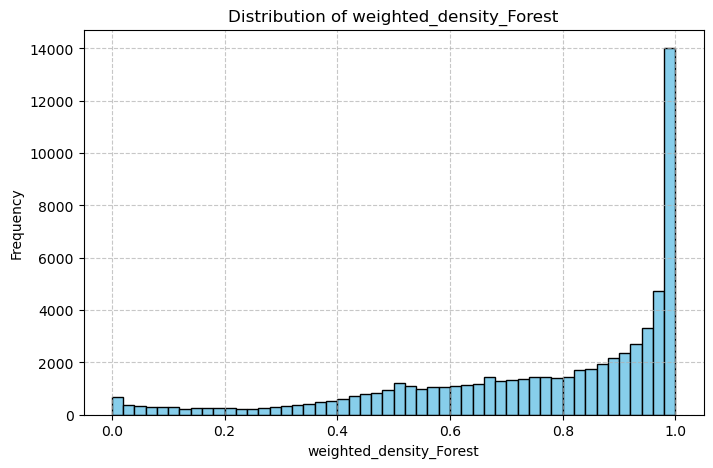

In [35]:
plt.figure(figsize=(8,5))
plt.hist(df_weight['weighted_density_Forest'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.xlabel('weighted_density_Forest')
plt.ylabel('Frequency')
plt.title('Distribution of weighted_density_Forest')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [51]:
df_net_benefit['current_abandonment'].value_counts()

current_abandonment
1    64982
Name: count, dtype: int64

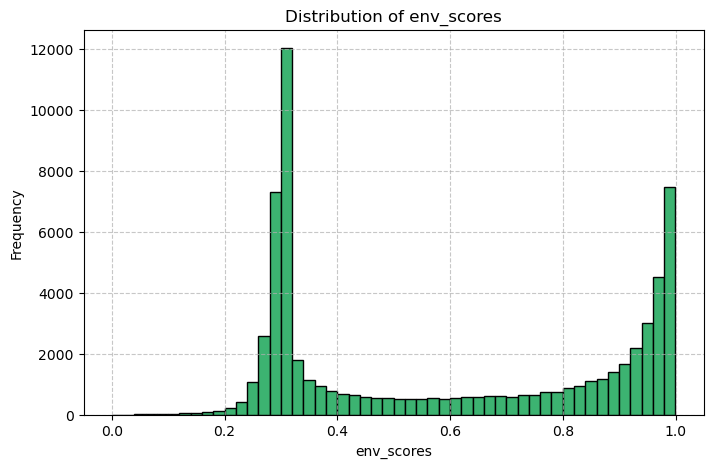

In [2]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8,5))
plt.hist(df_net_benefit['env_scores'].dropna(), bins=50, color='mediumseagreen', edgecolor='black')
plt.xlabel('env_scores')
plt.ylabel('Frequency')
plt.title('Distribution of env_scores')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()



In [2]:
import pandas as pd

df_deep=pd.read_csv('output/final_pv_suitability_best_ratio_0.3.csv')



df_deep






,Unnamed: 0,time,lat,lon,abandonment_year,abandonment_duration,current_abandonment,landcover,DEM,GDPpc,...,PrimaryRoad,SecondaryRoad,Slope,TertiaryRoad,gdmp,rsds,tas,wind,pv_suitability_prob,prediction_source
0,1897288,2020-01-01,31.320833,-105.929170,2014.0,10.0,1,2.0,1074.1250,19547.0,...,22.570979,20.346911,0.161280,109.755022,60.677334,21.335989,2934.915273,2.750262,0.000000,negative_sample
1,1899788,2020-01-01,31.329166,-105.929170,2014.0,10.0,1,3.0,1074.8125,19547.0,...,22.570979,20.346911,0.142680,109.755022,45.031578,21.334290,2934.829175,2.751782,0.000000,negative_sample
2,1902287,2020-01-01,31.337500,-105.937500,2014.0,10.0,1,3.0,1075.3750,32645.0,...,22.570979,20.346911,0.151240,109.755022,38.084999,21.337654,2934.583333,2.752204,0.000000,negative_sample
3,1902288,2020-01-01,31.337500,-105.929170,2014.0,10.0,1,2.0,1074.9375,32645.0,...,22.570979,20.346911,0.134330,109.755022,26.303532,21.336290,2934.584702,2.758872,0.000000,negative_sample
4,1904787,2020-01-01,31.345833,-105.937500,2014.0,10.0,1,2.0,1075.9375,32645.0,...,22.570979,20.346911,0.182301,109.755022,39.406666,21.343910,2934.581940,2.771071,0.000000,negative_sample
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64977,20192249,2020-01-01,46.937500,-67.920830,1998.0,26.0,1,2.0,199.3750,33949.0,...,4.273278,14.490743,1.000655,129.836817,74.197998,12.735363,2768.901404,3.429452,0.995299,model_prediction
64978,20247244,2020-01-01,47.145832,-67.962500,2000.0,24.0,1,2.0,223.0000,33949.0,...,32.119901,14.490743,3.852393,92.798418,73.082001,12.262959,2766.375025,3.813229,0.997037,model_prediction
64979,20271365,2020-01-01,47.237500,-68.620834,2000.0,24.0,1,2.0,181.2500,33949.0,...,3.471587,33.915221,1.910013,80.651057,54.858932,12.550031,2768.493367,3.047965,0.997259,model_prediction
64980,20275797,2020-01-01,47.254166,-68.354164,2000.0,24.0,1,2.0,244.9375,33949.0,...,8.030265,0.061349,1.939035,91.262543,74.170227,12.486876,2765.084545,4.128394,0.996994,model_prediction


## 经济分析

## 政策调整分析